<a id=top-page></a>
# `pykitPIV` demo: Generate a temporal sequence of PIV images

In this Jupyter notebook, we show how one can create a whole temporal sequence of PIV images by imposing particle coordinates in the `Particle` class object.
This can be useful whenever time-resolved intergration with machine learning (ML) is needed.

We demonstrate this on two flow cases: a compressible flow (where $\nabla \cdot \vec{\mathbf{V}} \neq 0$) and an incompressible (potential) flow (where $\nabla \cdot \vec{\mathbf{V}} = 0$). 
Notably, the compressible flow leads to clustering of particles in the regions of strongest divergence, while the incompressible flow, having zero divergence, cannot lead to clustering of particles.

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#compressible">Temporal sequence for a <b>compressible</b> flow</a></li>
        <ul>
        <li><a href="#generate-compressible-particles">Generate particles for the compressible flow</a></li>
        <li><a href="#generate-compressible-velocity-field">Generate compressible flow field to advect the particles</a></li>
        <li><a href="#add-movement">Add movement to particles</a></li>
        <li><a href="#animate">Animate</a></li>
        </ul>
    <li><a href="#incompressible">Temporal sequence for an <b>incompressible</b> flow</a></li>
        <ul>
        <li><a href="#generate-incompressible-particles">Generate particles for the incompressible flow</a></li>
        <li><a href="#generate-potential-velocity-field">Generate incompressible (potential) flow field to advect the particles</a></li>
        <li><a href="#add-movement">Add movement to particles</a></li>
        <li><a href="#animate">Animate</a></li>
        </ul>
</ol>
<p></p>
</div>
<br>

***

In [1]:
import numpy as np
import cmcrameri.cm as cmc
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from pykitPIV import Particle, FlowField, Motion, Image

2025-04-04 16:12:10.400911: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
save_images = False
n_images = 1
image_size = (200, 400)
size_buffer = 50
origin = 'lower'
figsize = (12,8)
time_separation = 0.4
filename = None

Specify PIV properties:

In [8]:
diameters = (3,3)
densities = (0.3, 0.3)
diameter_std = (0.2, 0.2)
exposures = (0.9, 0.9)
particle_loss = (10, 10)
particle_gain = 'matching'

<a id=compressible></a>
***

## Temporal sequence for a compressible flow

[Go to the top](#top-page)

In [9]:
title = 'Compressible flow'

<a id=generate-particles></a>

### Generate particles for the compressible flow

[Go to the top](#top-page)

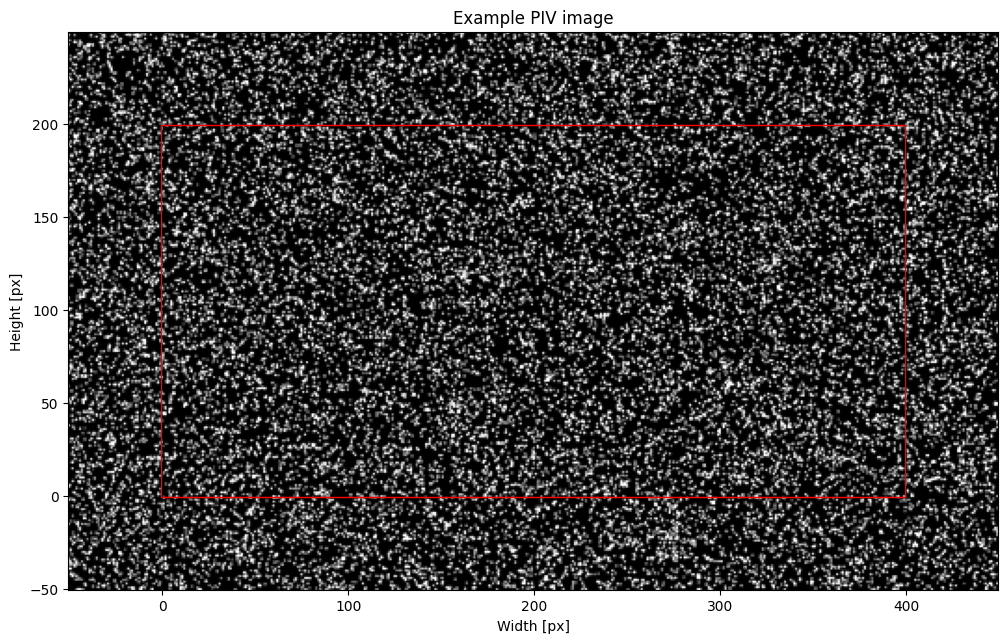

In [10]:
particles = Particle(n_images, 
                     size=image_size, 
                     size_buffer=size_buffer,
                     diameters=diameters,
                     densities=densities,
                     diameter_std=diameter_std,
                     seeding_mode='random', 
                     random_seed=100)

image = Image(random_seed=100)

image.add_particles(particles)

image.add_reflected_light(exposures=exposures,
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/20)

image.plot(0, 
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example PIV image',
           cmap='Greys_r',
           origin=origin,
           figsize=figsize);

<a id=generate-compressible-velocity-field></a>

### Generate compressible flow field to advect the particles

[Go to the top](#top-page)

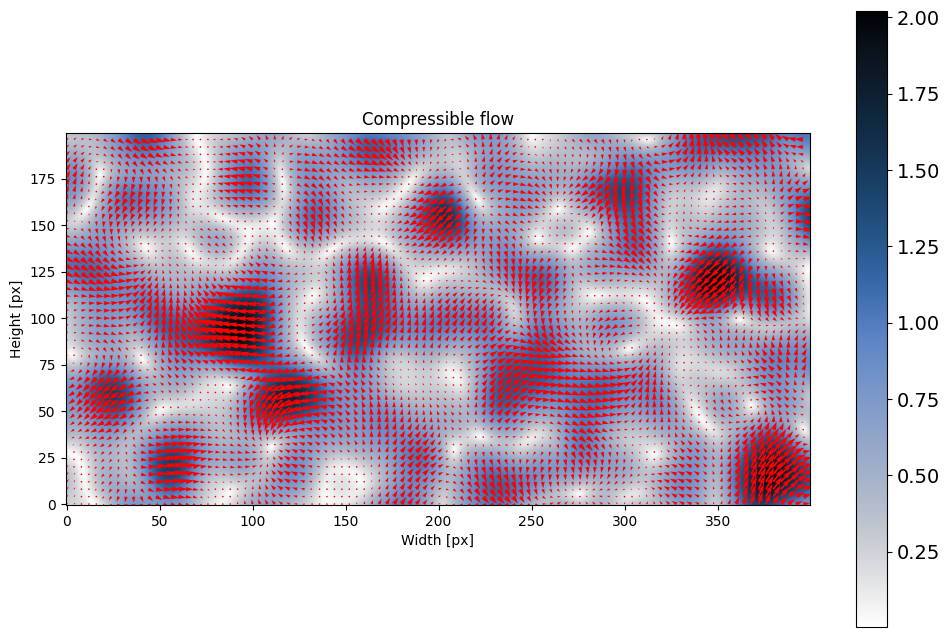

In [12]:
flowfield = FlowField(n_images,
                      size=image_size,
                      size_buffer=size_buffer,
                      random_seed=10)

flowfield.generate_random_velocity_field(gaussian_filters=(2,3),
                                         n_gaussian_filter_iter=20,
                                         displacement=(2,3))

image.add_flowfield(flowfield)

image.plot_field_magnitude(0,
                           with_buffer=False,
                           add_quiver=True,
                           quiver_step=4,
                           quiver_color='r',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title=title,
                           cmap=cmc.oslo_r,
                           figsize=figsize);

<a id=add-movement></a>

### Add movement to particles

[Go to the top](#top-page)

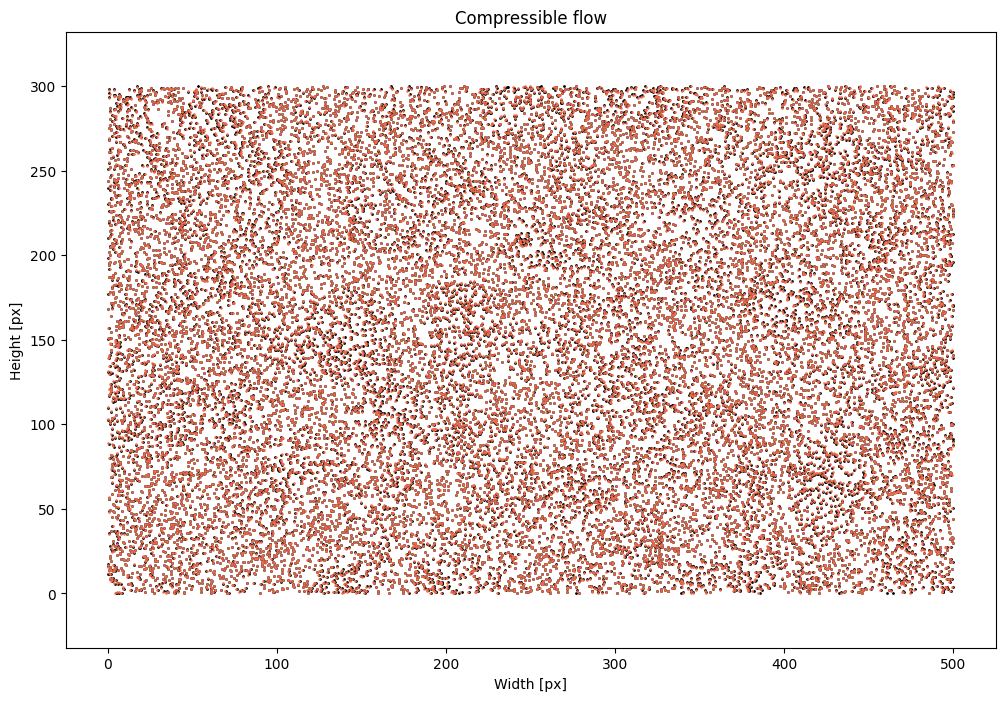

In [13]:
motion = Motion(particles, 
                flowfield, 
                time_separation=time_separation, 
                particle_loss=particle_loss, 
                particle_gain=particle_gain)

motion.forward_euler(n_steps=10)

motion.plot_particle_motion(0,
                            s=1,
                            xlabel='Width [px]',
                            ylabel='Height [px]',
                            title=title,
                            figsize=figsize);

image.add_motion(motion)

image.add_reflected_light(exposures=exposures,
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/20)

In [14]:
current_I2 = [image.remove_buffers(image.images_I2)]

for i in range(0,30):

    print('t = ' + str(round((i+2)*time_separation,1)) + 's')

    new_images_I1 = motion.particle_coordinates_I2
    
    particles.upload_particle_coordinates(new_images_I1)
    
    motion = Motion(particles, 
                    flowfield, 
                    time_separation=time_separation,
                    particle_loss=particle_loss, 
                    particle_gain=particle_gain)
    
    motion.runge_kutta_4th(n_steps=4)
    
    image.add_motion(motion)
    image.add_reflected_light(exposures=exposures,
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/20)

    current_I2.append(image.remove_buffers(image.images_I2))

t = 0.8s
t = 1.2s
t = 1.6s
t = 2.0s
t = 2.4s
t = 2.8s
t = 3.2s
t = 3.6s
t = 4.0s
t = 4.4s
t = 4.8s
t = 5.2s
t = 5.6s
t = 6.0s
t = 6.4s
t = 6.8s
t = 7.2s
t = 7.6s
t = 8.0s
t = 8.4s
t = 8.8s
t = 9.2s
t = 9.6s
t = 10.0s
t = 10.4s
t = 10.8s
t = 11.2s
t = 11.6s
t = 12.0s
t = 12.4s


### Animate

In [15]:
def animate_evolution(imagelist):

    fig = plt.figure(figsize=(6,6))

    im = plt.imshow(imagelist[0][0,0,:,:], cmap='Greys_r', origin=origin, animated=True)

    plt.title(title)
    
    def updatefig(j):

        im.set_array(imagelist[j][0,0,:,:])

        return [im]
    
    anim = animation.FuncAnimation(fig, updatefig, frames=range(len(current_I2)), interval=1, blit=True)
    
    anim.save('animate-compressible-PIV.gif', fps=20, bitrate=-1, dpi=150, savefig_kwargs={'bbox_inches' : 'tight'})
    
    return anim

MovieWriter ffmpeg unavailable; using Pillow instead.


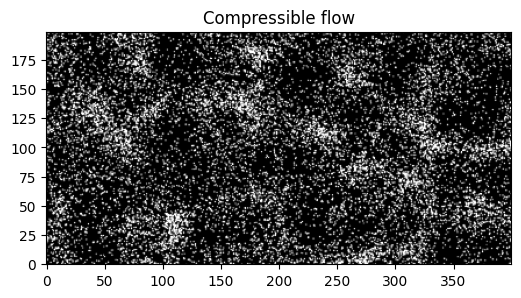

In [16]:
animate_evolution(current_I2)

<a id=incompressible></a>
***

## Temporal sequence for an incompressible flow

[Go to the top](#top-page)

In [28]:
title = 'Incompressible flow'

<a id=generate-particles></a>

### Generate particles

[Go to the top](#top-page)

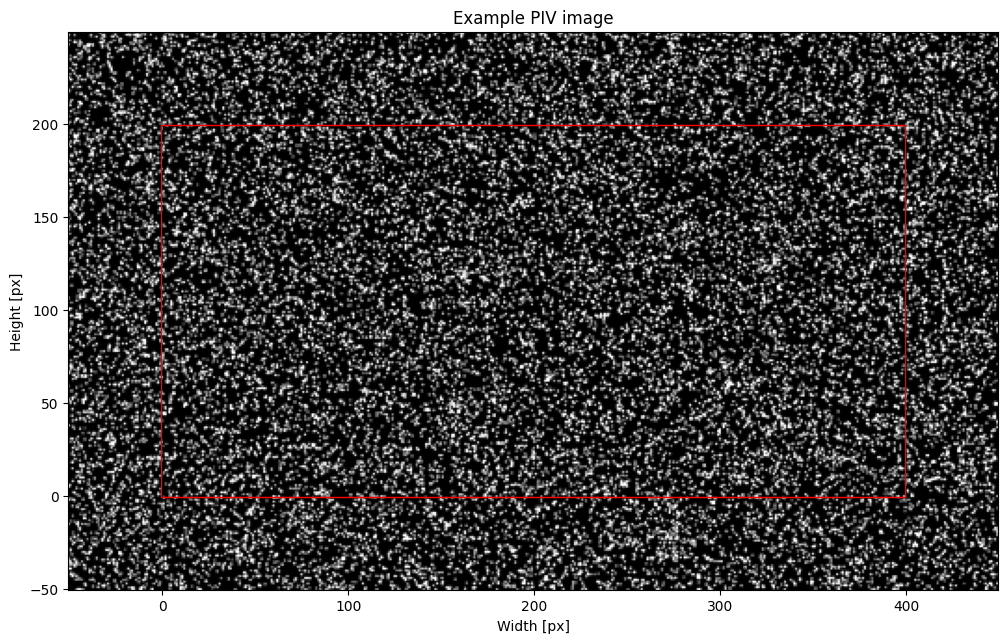

In [29]:
particles = Particle(n_images, 
                     size=image_size, 
                     size_buffer=size_buffer,
                     diameters=diameters,
                     densities=densities,
                     diameter_std=diameter_std,
                     seeding_mode='random', 
                     random_seed=100)

image = Image(random_seed=100)

image.add_particles(particles)

image.add_reflected_light(exposures=exposures,
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/20)

image.plot(0, 
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example PIV image',
           cmap='Greys_r',
           origin=origin,
           figsize=figsize);

<a id=generate-potential-velocity-field></a>

### Generate incompressible (potential) flow field to advect the particles

[Go to the top](#top-page)

The potential flow is divergence-free, therefore we will not see the effect of "clustering" of particles.

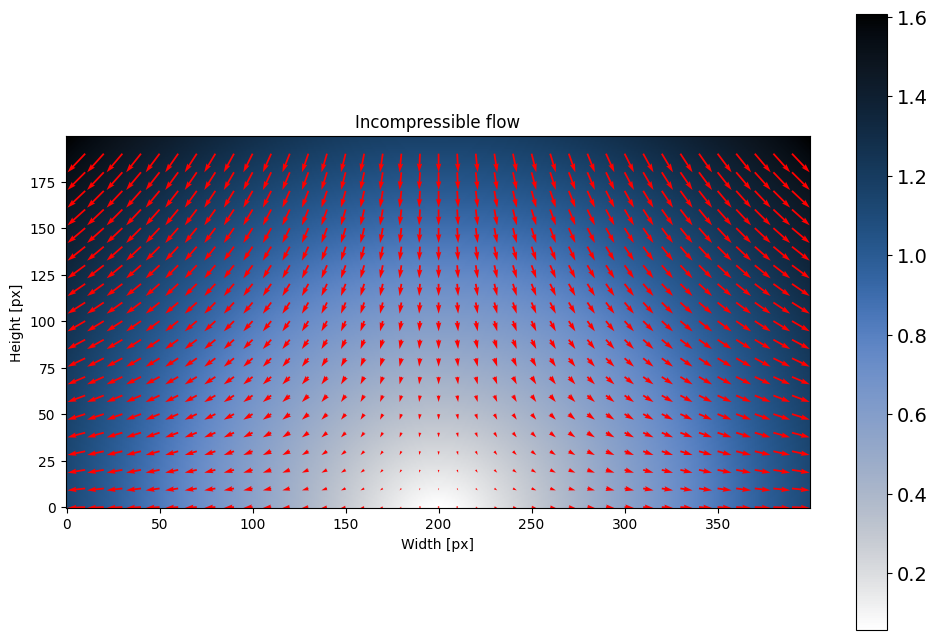

In [30]:
flowfield = FlowField(n_images,
                      size=image_size,
                      size_buffer=size_buffer,
                      random_seed=None)

flowfield.generate_potential_velocity_field(imposed_origin=(40,250),
                                            displacement=(2,2))

image.add_flowfield(flowfield)

image.plot_field_magnitude(0,
                           with_buffer=False,
                           add_quiver=True,
                           quiver_step=10,
                           quiver_color='r',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title=title,
                           cmap=cmc.oslo_r,
                           figsize=figsize);

<a id=add-movement></a>

### Add movement to particles

[Go to the top](#top-page)

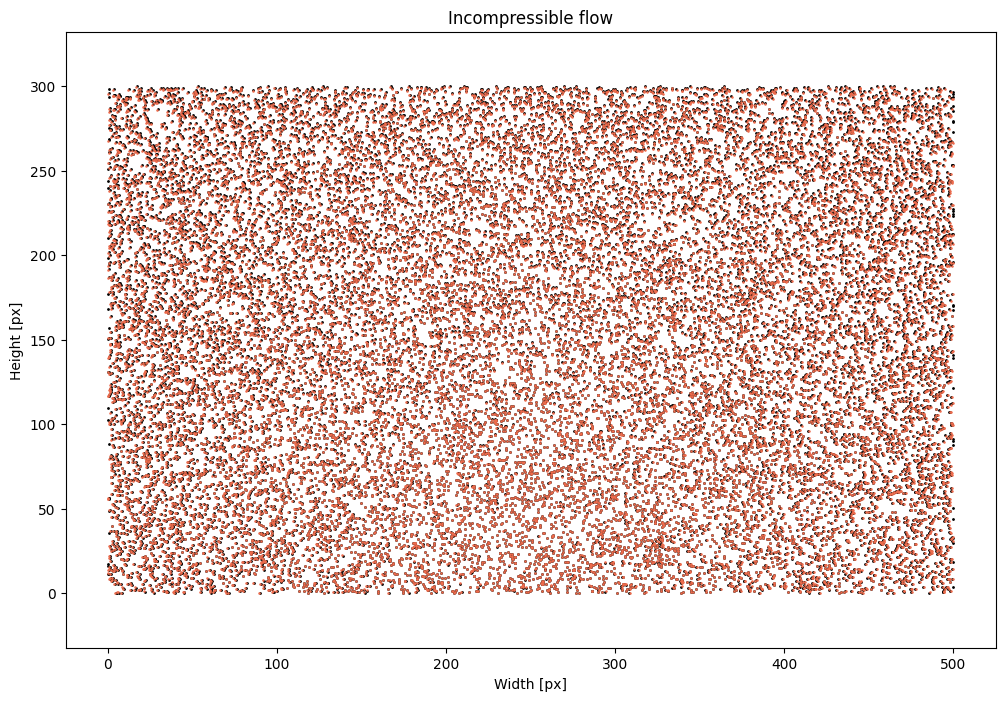

In [31]:
motion = Motion(particles, 
                flowfield, 
                time_separation=time_separation,
                particle_loss=particle_loss, 
                particle_gain=particle_gain)

motion.forward_euler(n_steps=10)

motion.plot_particle_motion(0,
                            s=1,
                            xlabel='Width [px]',
                            ylabel='Height [px]',
                            title=title,
                            figsize=figsize);

image.add_motion(motion)

image.add_reflected_light(exposures=exposures,
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/20)

In [32]:
current_I2 = [image.remove_buffers(image.images_I2)]

for i in range(0,60):

    print('t = ' + str(round((i+2)*time_separation,1)) + 's')

    new_images_I1 = motion.particle_coordinates_I2
    
    particles.upload_particle_coordinates(new_images_I1)
    
    motion = Motion(particles, 
                    flowfield, 
                    time_separation=time_separation,
                    particle_loss=particle_loss, 
                    particle_gain=particle_gain)
    
    motion.runge_kutta_4th(n_steps=4)
    
    image.add_motion(motion)
    image.add_reflected_light(exposures=exposures,
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/20)

    current_I2.append(image.remove_buffers(image.images_I2))

t = 0.8s
t = 1.2s
t = 1.6s
t = 2.0s
t = 2.4s
t = 2.8s
t = 3.2s
t = 3.6s
t = 4.0s
t = 4.4s
t = 4.8s
t = 5.2s
t = 5.6s
t = 6.0s
t = 6.4s
t = 6.8s
t = 7.2s
t = 7.6s
t = 8.0s
t = 8.4s
t = 8.8s
t = 9.2s
t = 9.6s
t = 10.0s
t = 10.4s
t = 10.8s
t = 11.2s
t = 11.6s
t = 12.0s
t = 12.4s
t = 12.8s
t = 13.2s
t = 13.6s
t = 14.0s
t = 14.4s
t = 14.8s
t = 15.2s
t = 15.6s
t = 16.0s
t = 16.4s
t = 16.8s
t = 17.2s
t = 17.6s
t = 18.0s
t = 18.4s
t = 18.8s
t = 19.2s
t = 19.6s
t = 20.0s
t = 20.4s
t = 20.8s
t = 21.2s
t = 21.6s
t = 22.0s
t = 22.4s
t = 22.8s
t = 23.2s
t = 23.6s
t = 24.0s
t = 24.4s



### Animate

In [33]:
def animate_evolution(imagelist):

    fig = plt.figure(figsize=(6,6))

    im = plt.imshow(imagelist[0][0,0,:,:], cmap='Greys_r', origin=origin, animated=True)

    plt.title(title)
    
    def updatefig(j):

        im.set_array(imagelist[j][0,0,:,:])

        return [im]
    
    anim = animation.FuncAnimation(fig, updatefig, frames=range(len(current_I2)), interval=1, blit=True)
    
    anim.save('animate-incompressible-PIV.gif', fps=20, bitrate=-1, dpi=150, savefig_kwargs={'bbox_inches' : 'tight'})
    
    return anim

MovieWriter ffmpeg unavailable; using Pillow instead.


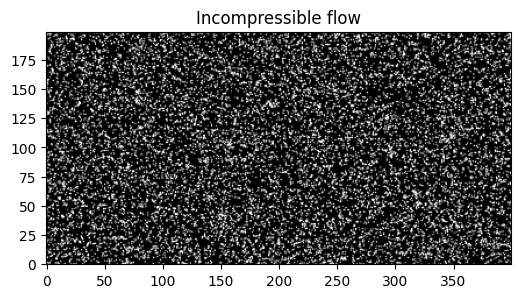

In [34]:
animate_evolution(current_I2)

***

© K. Zdybał, C. Mucignat, I. Lunati (2025)